In [27]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision, backend as K
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [28]:
# Mixed precision policy
mixed_precision.set_global_policy('mixed_float16')

# ================== PATHS & PARAMS ==================
TRAIN_DIR = '/teamspace/studios/this_studio/car_model_detection/data/processed/train'
VAL_DIR = '/teamspace/studios/this_studio/car_model_detection/data/processed/val'
MODEL_PATH = '/teamspace/studios/this_studio/car_model_detection/models/efficientnetv2s_car_model.keras'
IMG_SIZE = (384, 384)
BATCH_SIZE = 32
EPOCHS_PHASE1 = 20
EPOCHS_PHASE2 = 40

In [29]:
# ================== CUSTOM LAYERS ==================
class SpatialAttention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        super().build(input_shape)
        
    def call(self, x):
        avg_pool = K.expand_dims(K.mean(x, axis=-1), axis=-1)
        max_pool = K.expand_dims(K.max(x, axis=-1), axis=-1)
        concat = K.concatenate([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return layers.multiply([x, attention])

In [30]:
# ================== FIXED LOSS FUNCTION ==================
class WeightedFocalLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights, gamma=2.0, alpha=0.25, name='weighted_focal_loss'):
        super().__init__(name=name)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        # Compute per-sample cross-entropy
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, axis=-1)  # shape: (batch_size,)

        pt = tf.exp(-ce)
        alpha_t = self.alpha * tf.reduce_sum(y_true, axis=-1) + (1 - self.alpha) * (1 - tf.reduce_sum(y_true, axis=-1))
        
        sample_weights = tf.gather(self.class_weights, tf.argmax(y_true, axis=-1))  # shape: (batch_size,)
        focal_loss = sample_weights * alpha_t * tf.pow(1 - pt, self.gamma) * ce
        return tf.reduce_mean(focal_loss)

In [31]:
# ================== MODEL ARCHITECTURE ==================
def build_model(num_classes):
    base_model = EfficientNetV2S(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet',
        include_preprocessing=True
    )

    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs)
    x = SpatialAttention()(x)
    
    gap = layers.GlobalAvgPool2D()(x)
    gmp = layers.GlobalMaxPool2D()(x)
    x = layers.Concatenate()([gap, gmp])
    
    x = layers.Dense(192, activation='swish', kernel_regularizer='l2')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    return models.Model(inputs, outputs)

Found 840 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


Class weights: [1. 1. 1. 1.]


I0000 00:00:1750170133.356761    2239 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13949 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


🚀 Phase 1: Training head (frozen backbone)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1750170208.682519   29007 service.cc:152] XLA service 0x7fa650004020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750170208.682802   29007 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-06-17 14:23:30.991998: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750170225.079381   29007 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-06-17 14:23:59.264188: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k2=3,k4=2,k5=3,k6=3,k7=2} for conv %cudnn-conv.485 = (f16[32,192,192,24]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,385,385,3]{3,2,1,0} %bitcast.211734, f16[24,3,3,3]{3,2,1,0} %bitcast.211742), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", metadata={

10/27 ━━━━━━━━━━━━━━━━━━━━ 16s 970ms/step - accuracy: 0.2396 - loss: 4.2096

2025-06-17 14:26:07.635230: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k2=3,k4=2,k5=3,k6=3,k7=2} for conv %cudnn-conv.485 = (f16[8,192,192,24]{3,2,1,0}, u8[0]{0}) custom-call(f16[8,385,385,3]{3,2,1,0} %bitcast.211554, f16[24,3,3,3]{3,2,1,0} %bitcast.211562), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2D" op_name="functional_1/efficientnetv2-s_1/stem_conv_1/convolution" source_file="/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-17 14:26:07.726593: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2355 - loss: 3.9501

2025-06-17 14:27:51.634835: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k2=3,k4=2,k5=3,k6=3,k7=2} for conv %cudnn-conv.237 = (f16[16,192,192,24]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,385,385,3]{3,2,1,0} %bitcast.15160, f16[24,3,3,3]{3,2,1,0} %bitcast.15168), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2D" op_name="functional_1/efficientnetv2-s_1/stem_conv_1/convolution" source_file="/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-17 14:27:51.769257: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted

27/27 ━━━━━━━━━━━━━━━━━━━━ 342s 6s/step - accuracy: 0.2359 - loss: 3.9371 - val_accuracy: 0.2375 - val_loss: 2.9770 - learning_rate: 3.0000e-04
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2827 - loss: 2.7996 - val_accuracy: 0.2542 - val_loss: 2.3154 - learning_rate: 3.0000e-04
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4145 - loss: 2.1568 - val_accuracy: 0.4500 - val_loss: 1.8101 - learning_rate: 3.0000e-04
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5443 - loss: 1.7076 - val_accuracy: 0.5917 - val_loss: 1.4513 - learning_rate: 3.0000e-04
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6265 - loss: 1.3896 - val_accuracy: 0.6542 - val_loss: 1.2036 - learning_rate: 3.0000e-04
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6931 - loss: 1.1500 - val_accuracy: 0.7167 - val_loss: 1.0360 - learning_rate: 3.0000e-04
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7297 - loss: 0.9875 - 

2025-06-17 14:43:25.069997: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_243', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_327', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_329', 24 bytes spill stores, 24 bytes spill loads



27/27 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.9682 - loss: 0.1848 - val_accuracy: 0.8458 - val_loss: 0.2306
Epoch 22/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9751 - loss: 0.1777 - val_accuracy: 0.8583 - val_loss: 0.2234
Epoch 23/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9841 - loss: 0.1762 - val_accuracy: 0.8667 - val_loss: 0.2176
Epoch 24/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9788 - loss: 0.1747 - val_accuracy: 0.8792 - val_loss: 0.2183
Epoch 25/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9895 - loss: 0.1669 - val_accuracy: 0.8625 - val_loss: 0.2135
Epoch 26/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9817 - loss: 0.1647 - val_accuracy: 0.8917 - val_loss: 0.2104
Epoch 27/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9944 - loss: 0.1601 - val_accuracy: 0.8750 - val_loss: 0.2080
Epoch 28/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9760 - loss: 0.1580 - val_accuracy: 0.8833 - val_loss: 0.

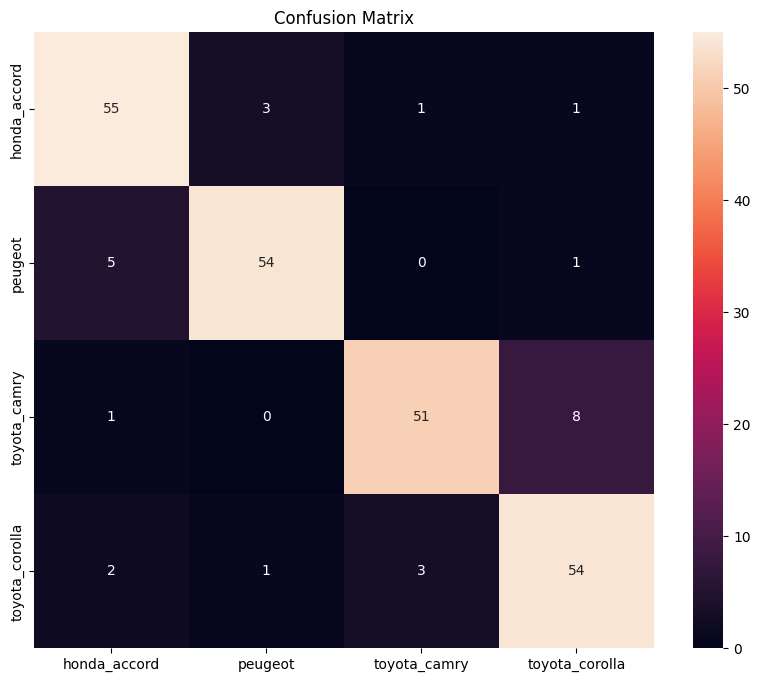

✅ Best validation accuracy: 89.17%


In [48]:
# ================== MAIN TRAINING FUNCTION ==================
def main():
    # Data pipeline
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        brightness_range=[0.9, 1.1],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    val_gen = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_gen.classes),
        y=train_gen.classes
    )
    print("Class weights:", class_weights)  # Debug print

    # Build model
    model = build_model(len(train_gen.class_indices))

    # Phase 1: Frozen base
    model.compile(
        optimizer=AdamW(learning_rate=3e-4),
        loss=WeightedFocalLoss(class_weights),
        metrics=['accuracy']
    )

    print("🚀 Phase 1: Training head (frozen backbone)")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS_PHASE1,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5),
            tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True)
        ]
    )

    # Phase 2: Gradual unfreeze
    print("🚀 Phase 2: Fine-tuning")
    for layer in model.layers[-30:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer=AdamW(learning_rate=1e-5),
        loss=WeightedFocalLoss(class_weights),
        metrics=['accuracy']
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS_PHASE1 + EPOCHS_PHASE2,
        initial_epoch=EPOCHS_PHASE1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
        ]
    )

    # Evaluation
    val_preds = model.predict(val_gen)
    print("\n📊 Classification Report:")
    print(classification_report(
        val_gen.classes,
        np.argmax(val_preds, axis=1),
        target_names=val_gen.class_indices.keys()
    ))
    
    # Confusion matrix
    cm = confusion_matrix(val_gen.classes, np.argmax(val_preds, axis=1))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=val_gen.class_indices.keys(), 
                yticklabels=val_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.show()
    
    model.save(MODEL_PATH)
    print(f"✅ Best validation accuracy: {max(history.history['val_accuracy']):.2%}")

if __name__ == "__main__":
    main()

Found 120 images belonging to 4 classes.

🔍 Running predictions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-06-17 22:53:58.892444: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 226492416 exceeds 10% of free system memory.
2025-06-17 22:53:59.813037: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 226492416 exceeds 10% of free system memory.
2025-06-17 22:54:00.829173: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 226492416 exceeds 10% of free system memory.


1/4 ━━━━━━━━━━━━━━━━━━━━ 1:20 27s/step

2025-06-17 22:54:19.722334: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 226492416 exceeds 10% of free system memory.
2025-06-17 22:54:20.655641: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 226492416 exceeds 10% of free system memory.


4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 20s/step

📊 Classification Report:
                precision    recall  f1-score   support

  honda_accord     0.7857    0.7333    0.7586        30
       peugeot     0.8667    0.8667    0.8667        30
  toyota_camry     0.7419    0.7667    0.7541        30
toyota_corolla     0.8387    0.8667    0.8525        30

      accuracy                         0.8083       120
     macro avg     0.8083    0.8083    0.8080       120
  weighted avg     0.8083    0.8083    0.8080       120



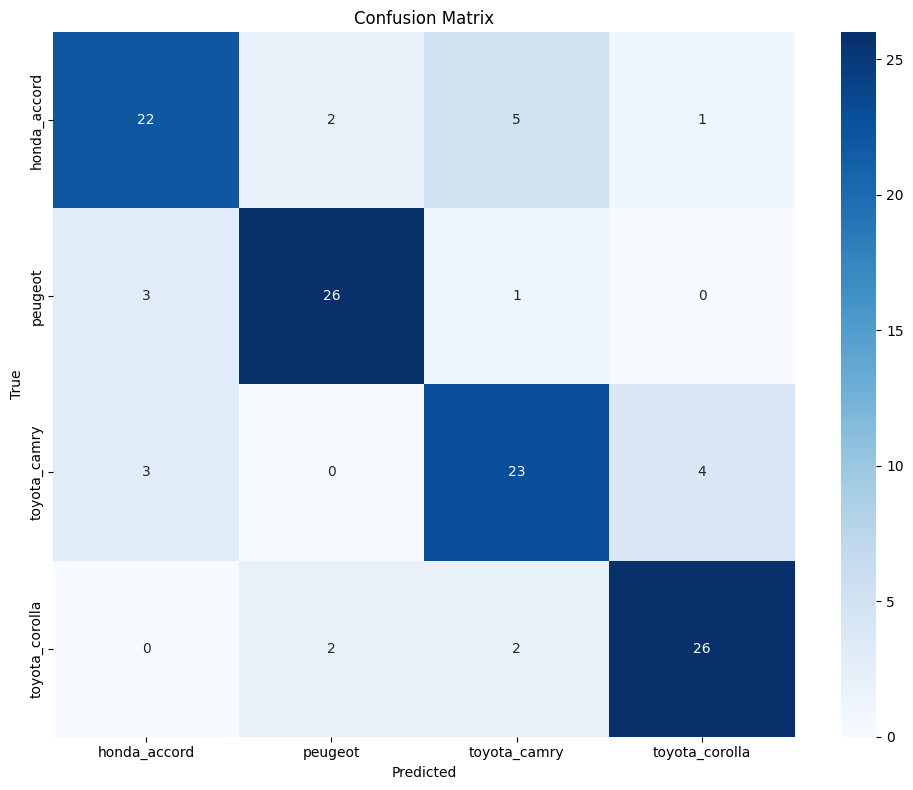


🎯 Per-Class Accuracy:
honda_accord   : 73.33%
peugeot        : 86.67%
toyota_camry   : 76.67%
toyota_corolla : 86.67%

❌ Found 23 misclassified samples


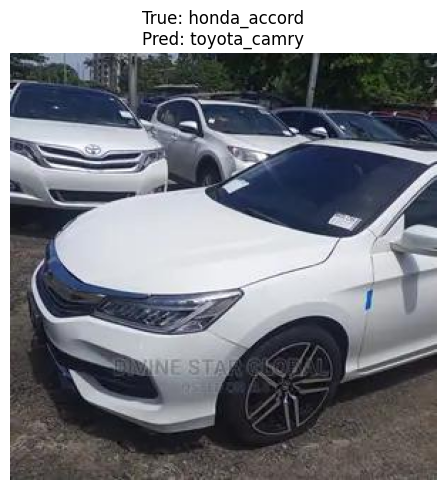

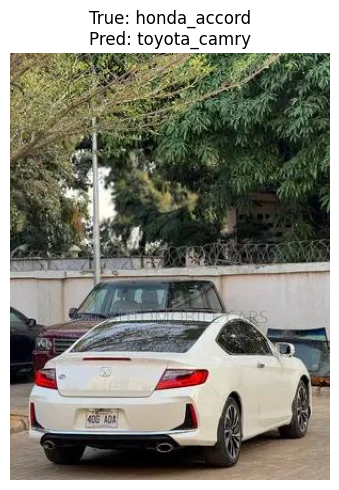

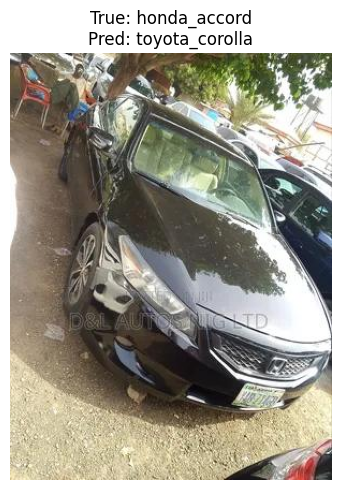

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ================== CONFIGURATION ==================
MODEL_PATH = '/teamspace/studios/this_studio/car_model_detection/models/efficientnetv2s_car_model.keras'  # Same as training
TEST_DIR = '/teamspace/studios/this_studio/car_model_detection/data/processed/test'  # Separate test set directory
IMG_SIZE = (384, 384)  # Must match training size
BATCH_SIZE = 32

# ================== FIXED CUSTOM LAYERS ==================
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(
            1, 
            kernel_size=7, 
            padding='same', 
            activation='sigmoid',
            dtype='float32'  # Force float32 for stable attention
        )
        super().build(input_shape)
        
    def call(self, x):
        x = tf.cast(x, tf.float32)  # Convert input to float32
        avg_pool = tf.expand_dims(tf.reduce_mean(x, axis=-1), axis=-1)
        max_pool = tf.expand_dims(tf.reduce_max(x, axis=-1), axis=-1)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        output = tf.multiply(x, attention)
        return tf.cast(output, x.dtype)  # Convert back to original dtype

class WeightedFocalLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights=None, gamma=2.0, alpha=0.25, name='weighted_focal_loss'):
        super().__init__(name=name)
        self.class_weights = class_weights if class_weights is not None else [1.0, 1.0, 1.0, 1.0]
        self.gamma = gamma
        self.alpha = alpha
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.exp(-ce)
        alpha_t = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        weights = tf.gather(tf.constant(self.class_weights, dtype=tf.float32), 
                          tf.argmax(y_true, axis=-1))
        loss = tf.reduce_mean(weights * alpha_t * tf.pow(1 - pt, self.gamma) * ce)
        return loss

# ================== EVALUATION PIPELINE ==================
def evaluate_model():
    # Enable mixed precision policy to match training
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    
    # Load model with custom objects
    model = load_model(
        MODEL_PATH,
        custom_objects={
            'SpatialAttention': SpatialAttention,
            'WeightedFocalLoss': WeightedFocalLoss
        },
        compile=False  # We don't need the optimizer for evaluation
    )
    
    # Prepare test data
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Get true labels and class names
    true_labels = test_gen.classes
    class_names = list(test_gen.class_indices.keys())
    
    # Generate predictions
    print("\n🔍 Running predictions...")
    predictions = model.predict(test_gen, steps=len(test_gen))
    predicted_labels = np.argmax(predictions, axis=1)
    
    # ============ EVALUATION METRICS ============
    print("\n📊 Classification Report:")
    print(classification_report(
        true_labels,
        predicted_labels,
        target_names=class_names,
        digits=4
    ))
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Per-Class Accuracy
    class_acc = cm.diagonal() / cm.sum(axis=1)
    print("\n🎯 Per-Class Accuracy:")
    for name, acc in zip(class_names, class_acc):
        print(f"{name:15}: {acc:.2%}")
    
    # Sample Errors
    error_mask = predicted_labels != true_labels
    if np.any(error_mask):
        error_indices = np.where(error_mask)[0]
        print(f"\n❌ Found {len(error_indices)} misclassified samples")
        
        # Display first 3 errors
        for i in range(min(3, len(error_indices))):
            idx = error_indices[i]
            img_path = test_gen.filepaths[idx]
            img = plt.imread(img_path)
            
            plt.figure(figsize=(5,5))
            plt.imshow(img)
            plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[predicted_labels[idx]]}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

if __name__ == "__main__":
    evaluate_model()